# COVID-19 Exponential Bayesian Model Backtesting

This notebook builds upon the exponential bayesian model to implement backtesting. The idea here is to hold out data, train a model, and see how well the model is able to predict those results.

Good models should be accurate (generate the same value) far into the future.

First, I am quickly regenerating the model described in [the exponential model](https://gitlab.com/winderresearch/covid/epidemic_model/-/blob/master/covid_exponential_model.ipynb).

In [1]:
!pip install arviz pymc3==3.8
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import theano

# Load data
df = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/", parse_dates=["dateRep"], infer_datetime_format=True, dayfirst=True)
df = df.rename(columns={'dateRep': 'date', 'countriesAndTerritories': 'country'}) # Sane column names
df = df.drop(["day", "month", "year", "geoId"], axis=1) # Not required

# Filter for country (probably want separate models per country, even maybe per region)
country = df[df["country"] == "United_Kingdom"].sort_values(by="date")
# Cumulative sum of data
country_cumsum = country[["cases", "deaths"]].cumsum().set_index(country["date"])
# Filter out data with less than 100 cases
country_cumsum = country_cumsum[country_cumsum["cases"] >= 100]

country = "United_Kingdom"
days_since_100 = range(len(country_cumsum))

## Creating the model

This is where `pymc3` gets a little non-standard. The typical pattern is to build a model, train a model, then call a prediction function with different data to see the predictions.

But remember that predictions in the MCMC case are actually chains of MC samples. In `pymc3`, the data is a part of the model. So how do you swap out the data in the model? Like any other software problem, you can do this in a few ways.

You could create a single model train it on the training data, then swap out the raw data with the holdout and generate the posterior predictions.

Alternatively, you can build a factory (model generation function) and call that twice with different data. I went with this option. Below I am building the factory.

In [0]:
def model_factory(country: str, x: np.ndarray, y: np.ndarray):
  with pm.Model() as model:
    t = pm.Data(country + "x_data", x)
    confirmed_cases = pm.Data(country + "y_data", y)

    # Intercept - We fixed this at 100.
    a = pm.Normal("a", mu=100, sigma=10)

    # Slope - Growth rate: 0.2 is approx value reported by others
    b = pm.Normal("b", mu=0.2, sigma=0.5)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Likelihood error
    eps = pm.HalfNormal("eps")

    # Likelihood - Counts here, so poission or negative binomial. Causes issues. Lognormal tends to work better?
    pm.Lognormal(country, mu=np.log(growth), sigma=eps, observed=confirmed_cases)
  return model

Now generate the holdout data. Simple to begin with. Could use cross-validation.

In [0]:
train_x = days_since_100[:-5]
train_y = country_cumsum["cases"].astype('float64').values[:-5]
hold_out_x = days_since_100[-5:]
hold_out_y = country_cumsum["cases"].astype('float64').values[-5:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, b, a]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:02<00:00, 396.03it/s]
The acceptance probability does not match the target. It is 0.9004074282186247, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9205165224709694, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 1000/1000 [00:10<00:00, 95.17it/s]


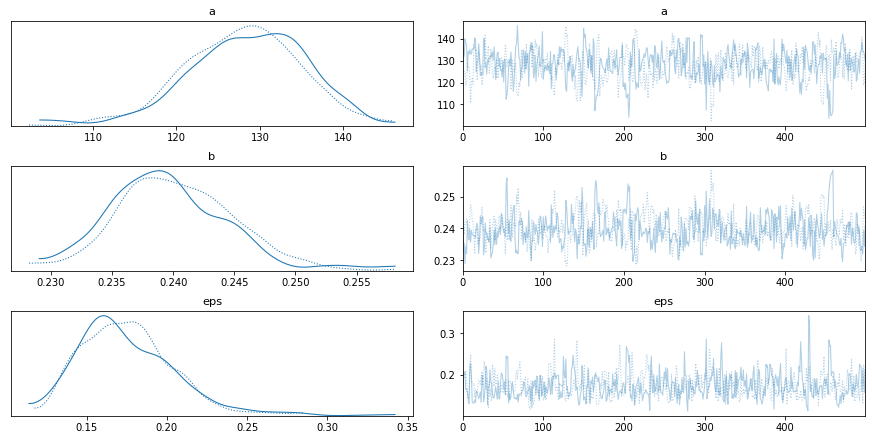

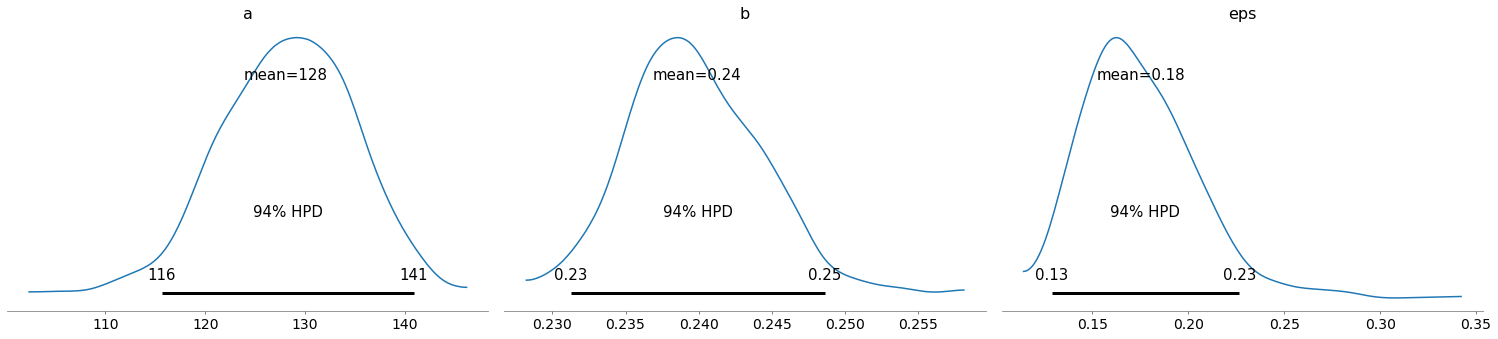

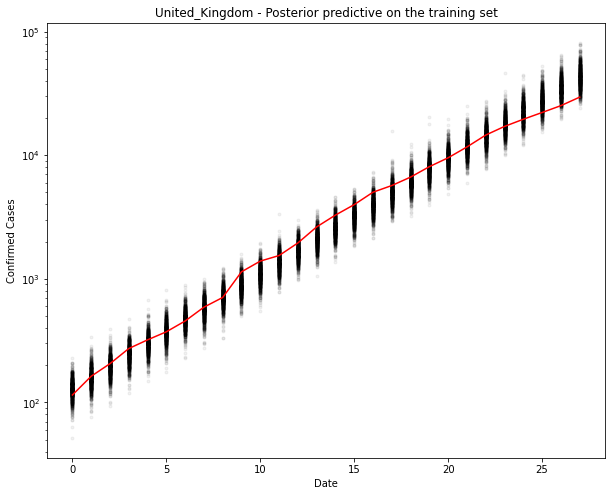

In [4]:
# Training
with model_factory(country, train_x, train_y) as model:
    train_trace = pm.sample()
    pm.traceplot(train_trace)
    pm.plot_posterior(train_trace)
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(train_x, ppc[country].T, ".k", alpha=0.05)
    ax.plot(train_x, train_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Date", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the training set")


In [9]:
# New model with holdout data
with model_factory(country, hold_out_x, hold_out_y) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(hold_out_x, ppc[country].T, ".k", alpha=0.05)
    ax.plot(hold_out_x, hold_out_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Date", ylabel="Confirmed Cases", title=f"{country} - Posterior predictive on the holdout set")

100%|██████████| 1000/1000 [00:10<00:00, 93.44it/s]


You can see above that the predictions are over the top of the observations. Makes sense. This is an exponential model. It can't go on for ever.

Remember that in a Bayesian model, the output is a probability distribution. The MCMC procedure has sampled from that distribution many times (each dot).

A single prediction, if you really want that, is the maximum likelihood of that distribution. For now, let me just use the mean. We could also get the confidence bounds in the same way.

In [6]:
# Generate the predicted number of cases (assuming normally distributed on the output)
predicted_cases = ppc[country].mean(axis=0).round()
print(predicted_cases)

[ 54159.  66867.  82414. 102269. 126764.]


### Prediction Errors

Start simple. The error is the difference between the predicted value (the mean of the MC estimates - note: assumes gaussian) and the actual data over 1 and 5 days.

The errors should be 0 cases and 0%. A positive value/percentatage means we have over-estimated.

In [7]:
def error(actual, predicted):
  return predicted - actual

def print_errors(actuals, predictions):
  for n in [1, 5]:
    act, pred = actuals[n-1], predictions[n-1]
    err = error(act, pred)
    print(f"{n}-day cumulative prediction error: {err} cases ({100 * err / act:.1f} %)")

print_errors(hold_out_y, predicted_cases)

1-day cumulative prediction error: 20441.0 cases (60.6 %)
5-day cumulative prediction error: 75156.0 cases (145.6 %)


## Discussion

Great. So now we have a way of producing a simple error metric based upon held-out data.

There are a number of ways we can make this more complicated:
- Using a random holdout (will make the results look better in this example)
- Backtesting over different time periods (i.e. not just the last 5 days, but 5 in the middle too)
- Cross-validation (training many models on different random holdouts and look at the average and standard deviation of those errors)
- Use more countries

But obviously the exponential model doesn't work very well. So next I will use a few countries and try a new model.

By the way, you can use the same approach to generate tomorrows cases. Just pass in a new x-value (of the same shape)

In [8]:
new_x = [hold_out_x[-1] + 1, hold_out_x[-1] + 5]
new_y = [0, 0]
# Predictive model
with model_factory(country, new_x, new_y) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
predicted_cases = ppc[country].mean(axis=0).round()
print("\n")
print(f"Based upon this model, tomorrow's number of cases will be {predicted_cases[0]}. In 5 days time there will be {predicted_cases[1]} cases.")
print("NOTE: These numbers are based upon a bad model. Don't use them!")

100%|██████████| 1000/1000 [00:10<00:00, 96.04it/s]



Based upon this model, tomorrow's number of cases will be 157520.0. In 5 days time there will be 375400.0 cases.
NOTE: These numbers are based upon a bad model. Don't use them!
